# Определение возраста покупателей

Задача:
* Провести исследование и обзор данных в датасете
* Построить и обучить модель прогнозирования возраста покупателей c целью предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, а также с целью проверки добросовестность кассиров при продаже алкоголя
* Метрика MAE должна быть не выше 8 лет

## Исследовательский анализ данных

Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузка данных с лицами

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Размер датасета

In [3]:
labels.shape

(7591, 2)

Обзор датасета

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пример некоторых изображений

Found 7591 validated image filenames.


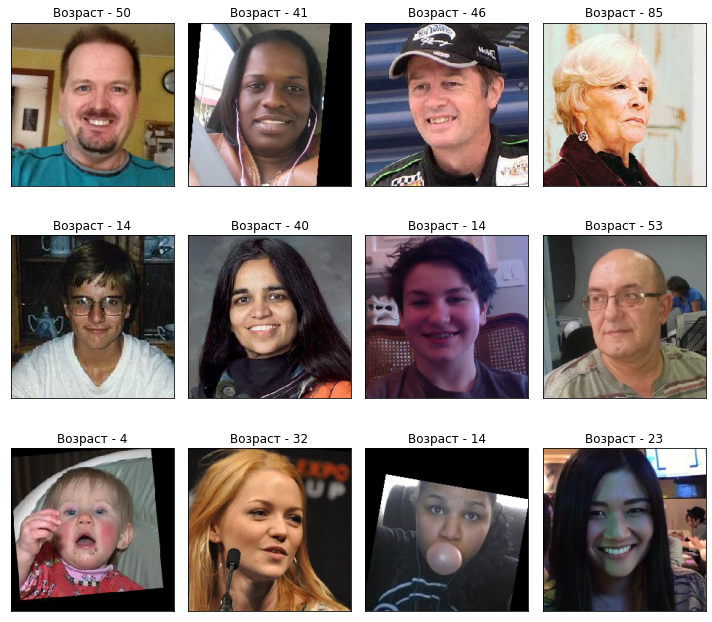

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

features, target = next(train_gen_flow)

# вывод фотографий
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.title('Возраст - ' +  str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Наличие пропусков в датасете

In [6]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

Наличие дубликатов в датасете

In [7]:
labels['file_name'].duplicated().sum()

0

Анализ возраста в датафрейме 

In [8]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Text(0, 0.5, 'Возраст')

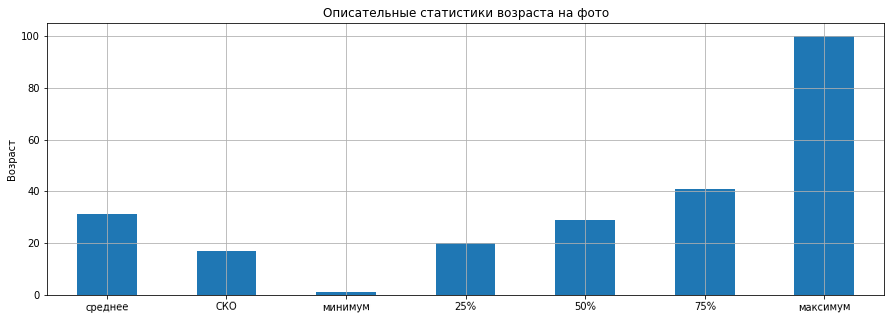

In [9]:
describe = labels['real_age'].describe()[1:]
describe = describe \
            .rename(index = {'mean' : 'среднее', 'std' : 'СКО','min': 'минимум', 'max': 'максимум'})

describe.plot(kind ='bar', figsize = (15,5),rot = 1, grid = True )
plt.title('Описательные статистики возраста на фото')
plt.ylabel('Возраст')

Text(0, 0.5, 'Частота встречающегося возраста')

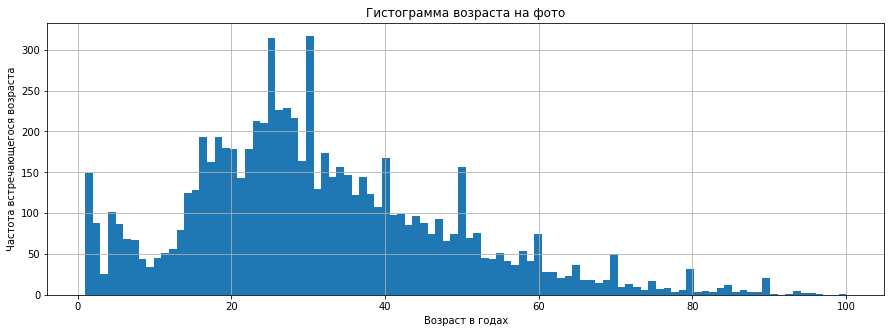

In [10]:
labels['real_age'].hist(bins = 100,figsize = (15,5))
plt.title('Гистограмма возраста на фото')
plt.xlabel('Возраст в годах')
plt.ylabel('Частота встречающегося возраста')

По исследованному датасету можно сделать некоторые выводы:
* В данных уже присутствуют аугментации изображений (повороты, разный масштаб лиц)
* Неравномерное распределение лиц по возрасту (значительно меньше данных в крайних возрастах), что может увеличивать ошибку при прогнозировании в возрастах с меньшим количеством фотографий
* Лица разных рас (возможно это как-то сказывается на качестве прогноза)

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```
Train for 356 steps, validate for 119 steps
Epoch 1/5
2023-03-04 15:39:51.642031: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-04 15:39:53.930713: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 76s - loss: 207.1819 - mae: 10.4322 - val_loss: 443.6273 - val_mae: 15.9154
Epoch 2/5
356/356 - 44s - loss: 82.4761 - mae: 6.8714 - val_loss: 189.7375 - val_mae: 10.0358
Epoch 3/5
356/356 - 43s - loss: 57.8244 - mae: 5.7910 - val_loss: 84.5769 - val_mae: 6.9760
Epoch 4/5
356/356 - 43s - loss: 42.8011 - mae: 4.9776 - val_loss: 110.1078 - val_mae: 7.7751
Epoch 5/5
356/356 - 43s - loss: 32.6516 - mae: 4.3866 - val_loss: 70.1409 - val_mae: 6.2271
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 70.1409 - mae: 6.2271
Test MAE: 6.2271
```

Тестирование модели показало достижение необходимого значения метрики MAE

## Анализ обученной модели

* Модель соответствует техническому заданию по метрике MAE, прогнозируемый ей возраст по фотографиям лиц дает в среднем абсолютную ошибку около 6 лет
* Если перед нами стоит задача предлагать  товар клиентам, то нужно в первую очередь ориентироваться на товары рассчитанные на диапазон в 2 MAE (чем шире возрастная категория товара тем лучше будет рекомендация на основании модели)
* С алкоголем труднее, так как MAE показывает ошибку в 6 лет на всей выборке возрастов. А наша задача иметь низкую ошибку в минус для совершеннолетних людей. В целом, при проверке кассира на продажу алкоголя пользоваться моделью можно осторожностью, и сравнивая кассиров между собой (если у кого-то будет подозрительно много  продаж алкоголя людям, возраст которых модели показался слишком маленьким, это повод задуматься о  качествах кассира)